<a href="https://colab.research.google.com/github/nkanu17/layoutlmv3-pytorch-lightning-fine-tuning/blob/main/layoutlmv3_pytorch_lightning_token_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-tune LayoutLMv3 for Token Classification with PyTorch Lightning

# Overview
The objective in this notebook is to show how to fine-tune LayoutLMv3 for token classification using *PyTorch Lightning*. 


The LayoutLM family of models, [developed by Microsoft](https://github.com/microsoft/unilm), have gained a lot of popularity in the field of document understanding. The models are able to handle a wide range of documents, including structured, semi-structured, and unstructured documents, and identify different elements such as texts, tables, and images to extract relevant information. This versatility makes them suitable for various document understanding tasks , such as form recognition, key information extraction, document layout analysis, and many more.

In this article, we will demonstrate how to fine-tune LayoutLMv3 for token classification using [PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/), a machine learning framework built on top of native PyTorch. Although other implementations of fine-tuning LayoutLMv3 already exist, this article aims to also discuss some of the advantages of using PyTorch Lightning.


[LayoutLMv3](https://arxiv.org/abs/2204.08387), a state of the art model in the field Document AI, involves understanding the structure and organization of documents, such as identifying text blocks, tables, figures, and other visual and textual elements. It is a new and improved version based on it's predecessors LayoutLM and LayoutLMv2.

The LayoutLMv3 model is capable of processing both the visual content (images) and textual content of documents simultaneously, which makes it highly effective for tasks like document classification (sequence classification), information extraction (token classification), and question answering.

Other approaches to fine-tune this model can be found through [Niels Rogge's LayoutLMv3 Tutorials](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv3/Fine_tune_LayoutLMv3_on_FUNSD_(HuggingFace_Trainer).ipynb).

**Acknowledgement**
- A big thanks to [Niels Rogge](https://github.com/NielsRogge) and their awesome [Transformers Tutorials](https://github.com/NielsRogge/Transformers-Tutorials.ipynb). I have learned a lot from their posts about using differnet SOTA models with Huggingface transformers.

**Advantages of PyTorch Lightning**

PyTorch Lightning is an open-source machine learning framework built by [Lightning AI](https://github.com/Lightning-AI)). It provides a high-level interface for machine learning experimentation, making it quicker and easier to train and test models. It is built around PyTorch, whose main difference is that it creates a new modular and object oriented approach to writing machine learning code. Some of the key advantages of PyTorch Lightning include:
- High-level interface
    - PyTorch Lightning automates many repetitive tasks associated with training deep learning models, we will see this in action below.
- Standardized structure and modularity
    - The framework promotes a clear separation between different parts of the model, such as the training loop, validation loop, and model architecture. It introduced the LightningDataModule and LightningModule, which allow improved readability, reusability, and easier integration with experimenting with different datasets and models.
- Automated Distributed training
    - One of the challenging and tedious aspects of training deep learning models is writing distributed training code. PyTorch Lightning takes away this complexity by providing built-in support for various distributed training strategies through a simple configuration within it's trainer.
- Integration with external experiment tools
    - Another key aspect of any machine learning project is experiment tracking.  PyTorch Lightning offers automatic integration with popular tools such as TensorBoard, MLflow, CometML, and Weights & Biases.
- Large community support
    - Community support for any project is important as it keeps them up-to-date. Imagine using a powerful frameowork that experiences a sudden stoppage in development (like Detectron2 :) ) - that would'nt be nice would it? - PyTorch Lightning is backed by an active open-source community and the LightningAI team, ensuring continuous development and improvement.
- Many more, I would encourage you to checkout their [repo](https://github.com/Lightning-AI/lightning) or [docs](https://lightning.ai/docs/pytorch/stable/)!

## Step 1: Set up the environment
Install the following packages:

In [1]:
# !pip install -q git+https://github.com/huggingface/transformers.git
# !pip install -q datasets
# !pip install -q pytorch_lightning
# !pip install -q torchmetrics==0.7.0

## Step 2: Obtain and observe the dataset and encodings

The dataset that we will use is to fine-tune the LayoutLMv3 for token classification is a sample of the [FUNSD](https://paperswithcode.com/dataset/funsd), Form Understanding in Noisy Scanned Documents, dataset. FUNSD is a benchmark dataset for document understanding tasks introduced by researchers at the University of California, Santa Barbara in 2019.

It contains scanned images of documents from different domains, such as invoices, tax forms, and resumes along with their corresponding annotations that include layout, structure, and content information. The dataset has become a popular benchmark for document understanding tasks, such as text extraction, entity recognition, and document layout analysis.

The dataset has become a popular benchmark for document understanding tasks, such as text extraction, entity recognition, and document layout analysis. It has also been used to evaluate the performance of various deep learning models, including all of the LayoutLM models.

In this notebook, we will use a pre-built FUNSD dataset from [Hugginface hub](https://huggingface.co/datasets/nielsr/funsd-layoutlmv3). It includes 149 train examples and 50 test examples, with OCR (Optical Character Recognition) already performed. 




### If we were not using this "ready-made" version of FUNSD

If we were not using this "ready-made" version of FUNSD, then we would have to generate the data ourselves. This process would include:
- Creating a dataset of documents, where for each document, it would consist of splitting all pages of a document into images
- Performing OCR (Optical Character Recognition) for all images to extract text and their location on the document - tokens and bounding boxes
- Labelling the images for a particular machine learning task. In case of token classification, we would need a label for each bounding box and their corresponding token

### Let's observe a sample of the data:

In [2]:
from datasets import load_dataset

dataset = load_dataset("nielsr/funsd-layoutlmv3")

  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 149
    })
    test: Dataset({
        features: ['id', 'tokens', 'bboxes', 'ner_tags', 'image'],
        num_rows: 50
    })
})

As can be seen above, the dataset includes:
- 149 train examples
- 50 test examples
- OCR already performed


It's features, seen below, contain:
- tokens (which are the words found in an image)
- bounding boxes (where the tokens are located in the image)
- ner_tags (labels of the tokens that we train the model to classify)
- image. 



In [4]:
dataset["train"].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'], id=None), length=-1, id=None),
 'image': Image(decode=True, id=None)}

### Let's observe an example plot the bounding boxes on the image

First we need to create index to label and label to index mapping, this is because the model will output an integer for each label and we need to be able to map these back to their original tags. Here we will use the code from [Niels Rogge's Transformers Tutorials](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/LayoutLMv3/Fine_tune_LayoutLMv3_on_FUNSD_(HuggingFace_Trainer).ipynb) to get the mapping

In [5]:
from datasets.features import ClassLabel

features = dataset["train"].features
column_names = dataset["train"].column_names
image_column_name = "image"
text_column_name = "tokens"
boxes_column_name = "bboxes"
label_column_name = "ner_tags"


# In the event the labels are not a `Sequence[ClassLabel]`, we will need to go through the dataset to get the
# unique labels.
def get_label_list(labels):
    unique_labels = set()
    for label in labels:
        unique_labels = unique_labels | set(label)
    label_list = list(unique_labels)
    label_list.sort()
    return label_list

if isinstance(features[label_column_name].feature, ClassLabel):
    label_list = features[label_column_name].feature.names
    # No need to convert the labels since they are already ints.
    idx_to_label = {k: v for k,v in enumerate(label_list)}
    label_to_idx = {v: k for k,v in enumerate(label_list)}
else:
    label_list = get_label_list(dataset["train"][label_column_name])
    idx_to_label = {k: v for k,v in enumerate(label_list)}
    label_to_idx = {v: k for k,v in enumerate(label_list)}
num_labels = len(label_list)

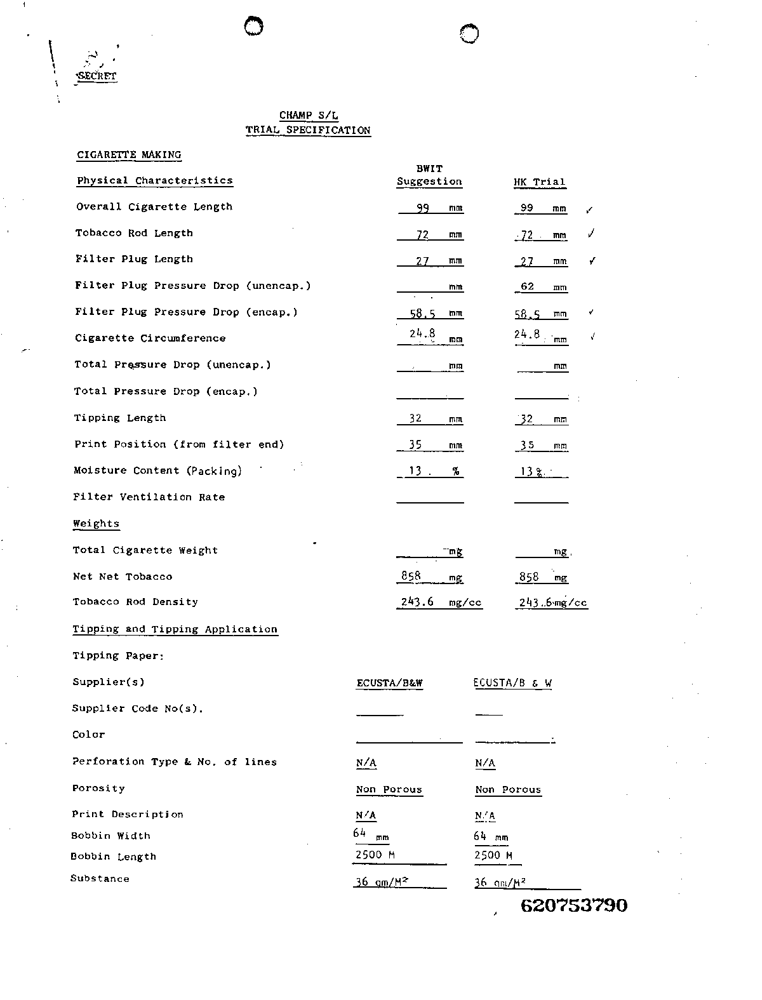

In [6]:
example = dataset["train"][10]
example['image']

### Now lets plot the bounding boxes and the ner_tags to visualize how the labelled data looks like

In [8]:
import numpy as np
import cv2
from PIL import Image as PilImage


def denormalize_bbox(box, width, height):
    # returning +1 due to rounding error during normalization
    return [
        int((box[0] / 1000) * width) + 1,
        int((box[1] / 1000) * height) + 1,
        int((box[2] / 1000) * width) + 1,
        int((box[3] / 1000) * height) + 1,
    ]

img = np.array(example['image'])
for label, bbox in zip(example['ner_tags'], example['bboxes']):
    
    bbox = denormalize_bbox(bbox, height = img.shape[0], width = img.shape[1])
    img = cv2.rectangle(img,  (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0, 255, 0), thickness=2)
    ner_tag = idx_to_label[label]
    
    # Optionally plot the label
    img = cv2.putText(
            img = img,
            text = ner_tag,
            org = (bbox[0]+5, bbox[1]),
            fontFace = cv2.FONT_HERSHEY_DUPLEX,
            fontScale = .3,
            color = (255, 0, 0),
            thickness = 1
        )

Well, its not the best image as the label font is not completely clear but you can still visualize the bounding boxes and what their labels are below. Anyway, the goal of token classification is for each image, we need to classify every token into a label, which are our NER-TAGS: 'O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER'

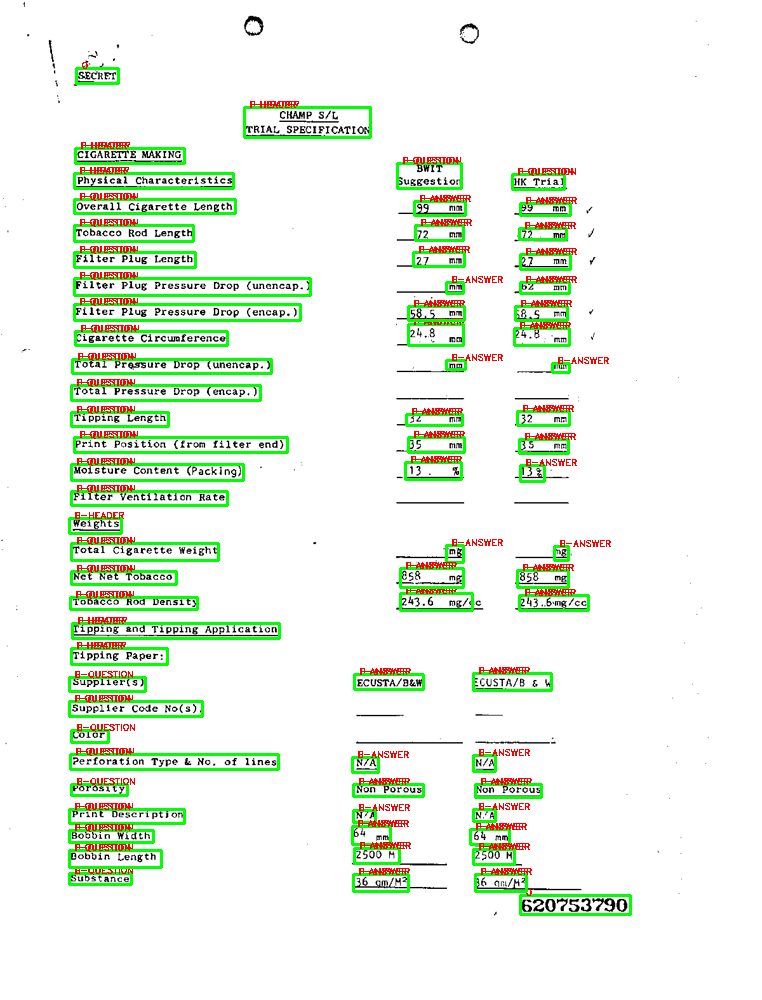

In [9]:
PilImage.fromarray(img)

As shown in the plotted image above, our example is a page resembling a specification sheet. Here the labels, ner_tags, are plotted in red and their corresponding bounding boxes in green. In this plotted image, we can see what data will be sent to the model and what needs to be extracted.

### Examine the encoded input
Now that we visualized an example from the training data, the next step is to encode the example in a way such that its acceptable by the model. As mentioned before, LayoutLMv3 requires both textual and visual information for processing and analysis; therefore, our data needs to be transformed and encoded into a format that is accepted by LayoutLMv3

Huggingface made it very easy for us to prepare data for the model through the [LayoutLMv3Processor](https://huggingface.co/docs/transformers/v4.27.2/en/model_doc/layoutlmv3#transformers.LayoutLMv3Processor). It combines the LayoutLMv3FeatureExtractor and LayoutLMv3Tokenizer into a single entity, making it easier to convert raw document data into the format required by the LayoutLMv3 model. 

The LayoutLMv3Processor first uses the [LayoutLMv3ImageProcessor](https://huggingface.co/docs/transformers/v4.27.2/en/model_doc/layoutlmv3#transformers.LayoutLMv3ImageProcessor) to resize and normalize document images, and optionally applies OCR to extract words and normalized bounding boxes (we do not need to do this). The resulting data is then passed to the [LayoutLMv3Tokenizer](https://huggingface.co/docs/transformers/v4.27.2/en/model_doc/layoutlmv3#transformers.LayoutLMv3Tokenizer) or [LayoutLMv3TokenizerFast](https://huggingface.co/docs/transformers/v4.27.2/en/model_doc/layoutlmv3#transformers.LayoutLMv3TokenizerFast), which converts the words and bounding boxes into token-level input_ids, attention_mask, token_type_ids, and bbox.

The following two code cells describe how to call define, initialize, and call the processor to get the encodings.

In [10]:
from transformers import AutoProcessor

# we are setting apply_ocr to False because we already performed OCR
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

In [11]:
# Note: LayoutLMv3 is a transformer and transformers generally have a maximum 
# input sequence length. Here, the max length is 512 tokens; therefore, we truncate 
# each sequence to 512 tokens and pad the sequences that are shorter than 512.

encoding = processor(
    example["image"],
    example["tokens"],
    boxes=example["bboxes"],
    word_labels=example["ner_tags"],
    return_tensors="pt",
    padding="max_length",
    truncation=True
)

The encoding returns input_ids, attention_mask, bbox, labels, and pixel_values.
 - **input_ids** refer to a tensor of the encoded tokenized input sequence. The input sequence is broken down into individual tokens or words and assigned a unique ID value. 0 and 1 here are the SEP (separator) and PAD tokens
 - **attention_mask** is a tensor that indicates which of the tokens need to be attended to and which do not. This is useful if the number of tokens in the input sequence is less than the max_length of tokens. 1 informs to attend while 0 says ignore.
 - **bbox** is a tensor of bounding boxes of the example image
 - **labels** is a tensor of of integer labels
 - **pixel_values** are the image pixels

 For more information, checkout the [Huggingface Glossary](https://huggingface.co/docs/transformers/main/glossary)



In [12]:
for key, value in encoding.items():
    print(f"{key}: {value}\n")

input_ids: tensor([[    0,  3614, 36995,   166,  6183, 13256, 14730,  1640,    29,    43,
         16858,  7879, 39533, 37506, 15408, 15408, 15408,   508,   207, 17844,
         17844,   234,    73,   250,   234,    73,   250,   234,    73,   250,
           234,    73,   250, 35794,  2545,  3272,  3248,  3858, 20014,   208,
            73,   226, 32725,  2118, 44921, 36497,  6034, 37170,  2068, 35825,
          1499, 19315, 24296,   230,  5969,  2747,  3935,  6433,  8981, 22889,
         23831, 35177, 16307,  7806, 38906, 43650, 41852, 20246,  6816, 41852,
         41263, 35079, 41852, 41263, 35079, 26324, 21603,    36,   879,   225,
         10906,  1592, 41263, 35079, 26324, 21603,    36,   225, 10906,  1592,
         38906, 43650, 26762,   783, 23861,  5480, 26324, 21603,    36,   879,
           225, 10906,  1592,  5480, 26324, 21603,    36,   225, 10906,  1592,
           255, 11813, 41852,  6883, 21355,    36,  7761, 14929,   253,    43,
          3713,   661,  2407,  1383,    3

Let's decode the encoded sequence and see if it matches the example tokens

In [13]:
" ".join(example["tokens"])

'SECRET Weights Supplier(s) Color Porosity Substance mm mm mm 13% mg mg N/A N/A N/A N/A 620753790 CHAMP S/ L TRIAL SPECIFICATION BWIT Suggestion HK Trial CIGARETTE MAKING Physical Characteristics Overall Cigarette Length Tobacco Rod Length Filter Plug Length Filter Plug Pressure Drop (unencap.) Filter Plug Pressure Drop (encap.) Cigarette Circumference Total Pressure Drop (unencap.) Total Pressure Drop (encap.) Tipping Length Print Position (from filter end) Moisture content (Packing) Filter Ventilation Rate Total Cigarette Weight Net Net Tobacco Tobacco Rod Density Tipping and Tipping Application Tipping Paper: Supplier Code No(s). Perforation Type & No. of lines Print Description Bobbin Width Dobbin Length ECUSTA/ B&W ECUSTA/ B & W Non Porous 64 mm 2500 M 36 nm/ M2 Non Porous 64 mm 2500 M 36 nm /47M2 243.6 mg/ cc 243.6 mg/ 858 mg 858 mg 35 mm 32 mm 32 mm 35 mm 13 % 24.8 mm 58.5 mm 24.8 mm 58.5 mm 62 mm 27 mm 72 mm 99 mm 99 mm 72 mm 27 mm'

In [14]:
processor.tokenizer.decode(encoding["input_ids"][0])

'<s> SECRET Weights Supplier(s) Color Porosity Substance mm mm mm 13% mg mg N/A N/A N/A N/A 620753790 CHAMP S/ L TRIAL SPECIFICATION BWIT Suggestion HK Trial CIGARETTE MAKING Physical Characteristics Overall Cigarette Length Tobacco Rod Length Filter Plug Length Filter Plug Pressure Drop (unencap.) Filter Plug Pressure Drop (encap.) Cigarette Circumference Total Pressure Drop (unencap.) Total Pressure Drop (encap.) Tipping Length Print Position (from filter end) Moisture content (Packing) Filter Ventilation Rate Total Cigarette Weight Net Net Tobacco Tobacco Rod Density Tipping and Tipping Application Tipping Paper: Supplier Code No(s). Perforation Type & No. of lines Print Description Bobbin Width Dobbin Length ECUSTA/ B&W ECUSTA/ B & W Non Porous 64 mm 2500 M 36 nm/ M2 Non Porous 64 mm 2500 M 36 nm /47M2 243.6 mg/ cc 243.6 mg/ 858 mg 858 mg 35 mm 32 mm 32 mm 35 mm 13 % 24.8 mm 58.5 mm 24.8 mm 58.5 mm 62 mm 27 mm 72 mm 99 mm 99 mm 72 mm 27 mm</s><pad><pad><pad><pad><pad><pad><pad><pad

## Step 3: Prepare data with the LightningDataModule

## Build Lightning Data Module
The general process of loading data for training machine learning model stays the same with PyTorch Lightning. We still need a build torch datasets and data loaders; however, the way they get passed into the model is something we can choose. For example, we can create our train_dataset, pass it onto a *train_dataloader*, and then use that during *model.fit()* or we can build a LightningDataModule and do it all in one place.

**What is the LightningDataModule and what are it's advantages?**
- The LightningDataModule is a standardized and improved way to maintain data.
- It contains all data related functionality in one place, including the data loading, processing, and transformation, making it easier to organize and maintain code.
- The standardization also makes the code more readable and easier to understand; while also ensuring  the reproducibility of results.
- Allows module to be easily shared and used for different runs of models

For more information about the LightningDataModule, please take a look at the [lightning guide](https://lightning.ai/docs/pytorch/stable/data/datamodule.html).

------

**Build the LightningDataModule**

Let's take a look at a simple demonstration of how to setup a data module for PyTorch Lightning. For more information, please take a look at the [lightning guide](https://lightning.ai/docs/pytorch/stable/data/datamodule.html) about the LightningDataModule.

Methods of the LightningDataModule we will use:
- setup
    - loads our dataset and splits it into train-test-validation sets
    - operations are performed on every GPU (distributed setting)
- train_dataloader
    - generate training dataloaders
- val_dataloader
    - generate validation dataloaders

Other useful methods that we do not need but can be found in the lightning guide:
- prepare_data
- test_dataloader
- predict_dataloader

Notes:
- First part here is to ensure that there is a method that downloads and loads the data. 
    - There are two methods for this process, prepare_data and setup. 
    - The prepare_data method downloads and saves our data onto disc, while setup downloads and loads the data into memory. For this demonstration, we will not use prepare_data. 
    - To load the dataset, we simply need to add the load_dataset(…) code from above inside the setup function. PyTorch Lightning will handle the calling and loading process under the hood.

- Next, we need to define our dataloaders. 
    - Lightning gave us the ability to build train, validation, test, and predict dataloaders.
    - We will only configure the train and validation loaders as our dataset only includes those.


In [15]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Processor
import pytorch_lightning as pl
from datasets import load_dataset

class FUNSDDataModule(pl.LightningDataModule):
    """
    PyTorch Lightning DataModule for FUNSD dataset.

    Args:
        dataset_name (str): name of the Hugging Face dataset to use
        processor_name (str): name of the Processor to use
        split_data (bool): whether to split data into train and test
        batch_size (int): size of the batches in the data loaders
        num_workers (int): number of workers for the data loaders
    """
    def __init__(self, dataset_name="nielsr/funsd-layoutlmv3", processor_name = "microsoft/layoutlmv3-base", split_data = False, batch_size=4, num_workers=4):
        super().__init__()
        self.dataset_name = dataset_name
        self.split_data = split_data
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.processor = AutoProcessor.from_pretrained(processor_name, apply_ocr=False)

    def setup(self, stage=None):
        """
        Downloads and prepares the dataset for the Lightning DataModule.
        """
        dataset = load_dataset(self.dataset_name)
        if not self.split_data:
            self.train_data = dataset["train"]
            self.val_data = dataset["test"]

    def train_dataloader(self):
        """
        Returns the training DataLoader.
        """
        return DataLoader(self.train_data, batch_size=self.batch_size, collate_fn=self.collate_fn, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        """
        Returns the validation DataLoader.
        """
        return DataLoader(self.val_data, batch_size=self.batch_size, collate_fn=self.collate_fn, num_workers=self.num_workers)

    def collate_fn(self, batch):
        """
        Collate function to convert a batch of input data into encodings.

        Args:
            batch (list): List of samples

        Returns:
            dict: Dictionary of input tensors
        """
        encodings={'input_ids':[], 'attention_mask':[], 'bbox':[], 'labels':[], 'pixel_values':[]}
        
        # Loop through each item in the batch and encode it using
        # the LayoutLMv3 processor.
        for item in batch:
            encoding = self.processor(
                item["image"],
                item["tokens"],
                boxes=item["bboxes"],
                word_labels=item["ner_tags"],
                return_tensors="pt",
                padding="max_length",
                truncation=True
            )
            encodings['input_ids'].append(encoding['input_ids'])
            encodings['attention_mask'].append(encoding['attention_mask'])
            encodings['bbox'].append(encoding['bbox'])
            encodings['labels'].append(encoding['labels'])
            encodings['pixel_values'].append(encoding['pixel_values'])

        # the final input needs to be a dict of tensors
        for k, v in encodings.items():
            encodings[k] = torch.cat(v)
        return encodings


## Step 4: Build the Lightning Module for Modeling
The [LightningModule](https://lightning.ai/docs/pytorch/stable/common/lightning_module.html) organizes our training, validation, and testing code into a standardized and modular format. The following are the key components of the LightningModule:

- Initialization and definition of model (Required)
    - This is where you define the architecture of your neural network and initialize it and other parameters.
- Training process (Required)
    - Here, you specify the process for training the model, including how data is fed into the network and how the optimizer is applied.
- Optimization setup (Required)
    - This section includes the optimizer and learning rate scheduler used to update the model's parameters during training.
- Validation process (Optional)
    - During training, a small portion of the training data is typically used for validation to determine when the model has finished training. This section outlines that process.
- Test process (Optional)
    - After training, a separate test split is typically used to evaluate the model's performance. This section outlines the process for that step.
- Prediction process (Optional)
    - This section performs the prediction/inference using the model after training.

To reiterate, some of the advantages are modularity, standardized and cleaner code, improved reproducibility, automatic handling of distributed training. Learn more to comprehensive overview from the [LightningModule docs](https://pytorch-lightning.readthedocs.io/en/1.6.0/common/lightning_module.html).

----
To setup our LightningModule, we should configure the following methods:
- __init__
    - holds the model definition and other parameters
- forward()
    - defines the forward pass of the model, which takes an input and produces an output
- training_step()
    - defines the training loop for the model. It takes in a batch of data, performs a forward pass through the model, calculates the loss, and returns a dictionary of values to log for the current step.
- configure_optimizers()
    - defines the optimizer and schedular used to update the model's parameters during training.
    - can be customized to use multiple learning rate schedulers and optimizers if needed. I use *get_linear_schedule_with_warmup()* from HuggingFace as my learning rate scheduler and *Adam* for my optimizer.
- validation_step()
    - defines the validation loop for the model. It takes in a batch of data, performs a forward pass through the model, calculates the loss, and returns a dictionary of values to log for the current validation step.
    - Additionally we do performance metric calculation using MetricCollection from torchmetrics to calculate the F1, Precision, Recall, and Accuracy here
- on_validation_epoch_end()
    - aggregates the results of the validation step across all batches in an epoch and returns a dictionary of values to log for the epoch
    - it can also be customized to perform an evaluation at the end of each epoch

Everything else that we do not see happens "under the hood". Furthermore, PyTorch Lightning provides additional methods in the LightningModule class that allow for advanced customization, bringing more control closer to traditional PyTorch. Check out the [Lightning guide](https://lightning.ai/docs/pytorch/stable/api/lightning.pytorch.core.LightningModule.html?highlight=training_step#lightning.pytorch.core.LightningModule.training_step)  for more information on these methods.


In [16]:
import numpy as np
import torch
from torchmetrics import MetricCollection, Precision, Recall, F1, Accuracy
from transformers import get_linear_schedule_with_warmup


class LayoutLMv3Model(pl.LightningModule):
    """LightningModule for LayoutLMv3 model."""

    def __init__(
        self, 
        model,
        id2label, 
        label2id, 
        warmup_steps, 
        total_training_steps, 
        learning_rate=1e-4,
        model_path_or_name="microsoft/layoutlmv3-base"
    ):
        """
        Initializes the LayoutLMv3Model.

        Args:
            id2label (dict): A dictionary containing mapping from label id to label.
            label2id (dict): A dictionary containing mapping from label to label id.
            learning_rate (float): The learning rate to use during training.
        """
        super().__init__()
        self.learning_rate = learning_rate
        self.warmup_steps = warmup_steps
        self.total_training_steps = total_training_steps
        self.model=LayoutLMv3ForTokenClassification.from_pretrained(
            model_path_or_name, id2label=id2label, label2id=label2id
        )

        self.metric_collection = MetricCollection({
            'precision': Precision(num_classes=len(label2id)),
            'recall': Recall(num_classes=len(label2id)),
            'f1': F1(num_classes=len(label2id)),
            'accuracy': Accuracy(),
        })

    def forward(self, input_ids, attention_mask, bbox, pixel_values, labels=None):
        """
        The forward pass of the model, which takes an input and produces an output.

        Args:
            input_ids (Tensor): The input tensor containing token ids.
            attention_mask (Tensor): The attention mask tensor.
            bbox (Tensor): The bounding box tensor.
            pixel_values (Tensor): The pixel value tensor.
            labels (Tensor): The labels tensor. Defaults to None.

        Returns:
            The output of the model.
        """
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            bbox=bbox,
            pixel_values=pixel_values,
            labels=labels,
        )

    def training_step(self, batch, batch_idx):
        """
        Performs a single training step on a batch of data.

        Args:
            batch (Dict): The dictionary containing the batch data.
            batch_idx (int): The index of the current batch.

        Returns:
            The loss calculated during training.
        """
        inputs = {key: value for key, value in batch.items() if key != "labels"}
        outputs = self(**inputs, labels=batch["labels"])
        loss = outputs.loss
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        """
        Configures the optimizer and learning rate scheduler used during training.

        Returns:
            A dictionary containing the optimizer and learning rate scheduler.
        """
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=self.warmup_steps, num_training_steps=self.total_training_steps
        )
        return dict(optimizer=optimizer, lr_scheduler=dict(scheduler=scheduler, interval="step"))
    
    def validation_step(self, batch, batch_idx):
        """
        Performs a single validation step on a batch of data. 
        This includes updating the validation loss and performance metrics.

        Args:
            batch (Dict): The dictionary containing the batch data.
            batch_idx (int): The index of the current batch.

        Returns:
            The loss calculated during validation.
        """
        inputs = {key: value for key, value in batch.items() if key != "labels"}
        outputs = self(**inputs, labels=batch["labels"])
        loss = outputs.loss
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
        preds = probs.argmax(dim=-1)
        targets = batch["labels"]
        
        # filter out negative labels such as -100 
        # that are used for our special tokens
        mask = targets >= 0
        preds = preds[mask]
        targets = targets[mask]
        
        self.metric_collection.update(preds, targets)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        """
        Computes and logs the validation set metrics at the end of the epoch.

        Args:
            outputs: The outputs of all validation steps during the epoch.
        """
        metrics = self.metric_collection.compute()
        
        # lets neatly print the metrics
        print(f"\nValidation Metrics Epoch {self.current_epoch}:")
        for k, v in metrics.items():
            print(f"{k}: {v}")

        self.log_dict(metrics)
        self.metric_collection.reset()

## Step 5: Define the Trainer and train the model

Finally what we've been waiting for! Traaaaining! This is always my favorite part of machine learning process - it can be the make or break part of an experiment as the wait to see the fruitful results is quite exciting(although machine learning experiments often fail, but that's for another day). 

Anyway, to train the model, we must first define the PyTorch Lightning Trainer. 
- Did you wonder where the calls like *model.train(), model.eval(), optimizer.zero_grad(), optimizer.step(),* and *loss.backward()* were? 
    - Well, all that is handled "under the hood" by the Trainer! It also offers many more options for experimentation and configuration than what is used in this demonstration. 
    - If you wan't to understand the full capabilities of the [Trainer](https://lightning.ai/docs/pytorch/stable/common/trainer.html) docs.

In the past, writing multi-gpu training code from scratch was a laborious task, regardless of the distributed training strategy you wanted to use. But with PyTorch Lightning, you can now easily choose from a range of distributed training strategies simply by configuring the Trainer. This means you can test multiple models with different datasets without having to write distributed code for each one. I would suggest one to read up on the different [accelerators](https://lightning.ai/docs/pytorch/stable/extensions/accelerator.html) and [strategies](https://lightning.ai/docs/pytorch/stable/extensions/strategy.html) we can use easily.


Imagine the time and effort saved by not having to write distributed code for every single model you test. PyTorch Lightning Trainer takes care of the heavy lifting so you can focus on the fun part - experimenting with different models and datasets!

For this tutorial, we will focus on single GPU training. Therefore, the Trainer is configured with only 1 GPU. Additionally, I want the model to train for 5 epochs, performing a validation check at the end of each epoch. I also use the TQDMProgressbar for a cleaner progress tracking.

Finally, the training can start by calling trainer.fit method, passing in the model and data module! That's it to get this model training!

In [17]:
from pytorch_lightning.callbacks import TQDMProgressBar

batch_size = 2
total_training_steps = len(dataset["train"]) // batch_size
warmup_steps = int(total_training_steps * 0.1)

data_module = FUNSDDataModule(batch_size=batch_size)

lmv3_model = LayoutLMv3ForTokenClassification.from_pretrained(
            "microsoft/layoutlmv3-base", id2label=idx_to_label, label2id=label_to_idx
        )


Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
model = LayoutLMv3Model(
    lmv3_model,
    idx_to_label, 
    label_to_idx, 
    warmup_steps, 
    total_training_steps, 
    learning_rate=1e-4
)

# create the trainer
trainer = pl.Trainer(
        accelerator="gpu",
        devices=1,
        max_epochs=5,
        check_val_every_n_epoch=5,
        callbacks=[TQDMProgressBar(refresh_rate=2)]
    )

trainer.fit(model, datamodule=data_module)

/usr/local/lib/python3.9/dist-packages/deprecate/deprecation.py:115: FutureWarning: The `F1` was deprecated since v0.7 in favor of `torchmetrics.classification.f_beta.F1Score`. It will be removed in v0.8.
  stream(template_mgs % msg_args)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name              | Type                             | Params
-----------------------------------------------------------------------
0 | model             | LayoutLMv3ForTokenClassification | 125 M 
1 | metric_collection | MetricCollection                 | 0     
-----------------------------------------------------------------------
125 M     Trainable params
0         Non-trainable params
125 M     Total params
501.329   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.9/dist-packages/transformers/modeling_utils.py:827: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(



Validation Metrics Epoch 0:
accuracy: 0.08827085793018341
f1: 0.08827085793018341
precision: 0.08827085793018341
recall: 0.08827085793018341


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]


Validation Metrics Epoch 4:
accuracy: 0.7988826632499695
f1: 0.7988826632499695
precision: 0.7988826632499695
recall: 0.7988826632499695


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
